In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Effect of bias on WGA for $m=0$:
Showing the effect of the number of collaborators $N$ and the cumulative bias $\zeta^2T$.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


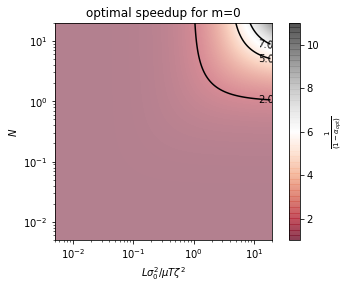

In [ ]:
def z_func(x,y):
 return 1 / (1 + 1 / x + 1 / y)

x = np.linspace(0.005,20,10000)
y = np.linspace(0.005,20,10000)

X,Y = np.meshgrid(x, y) # grid of point
Z1 = 1 / (1 - z_func(X, Y)) 


contours = plt.contour(X, Y, Z1, [2,5,7], colors='black')
plt.clabel(contours, inline=True, fontsize=10)

plt.imshow(Z1, extent=[0.005, 20, 0.005, 20], origin='lower',
           cmap='RdGy', alpha=0.5)

plt.xscale("log")
plt.yscale("log")

plt.axis(aspect='image')
plt.colorbar(label=r"$\frac{1}{(1-\alpha_{opt})}$");
plt.xlabel(r"$L \sigma_0^2/\mu T \zeta^2 $")
plt.ylabel("$N$")
plt.title("optimal speedup for m=0")


plt.savefig("gain factor.pdf")

## Effect of $m$ on WGA for $\zeta=0$

In [ ]:
import sympy as sp

x,m,N = sp.symbols("x,m,N")

f = ((1 - x)**2 + x**2 / N) / (1 - x**2*m)**2 #+ x**2 * zeta**2/(1 - x**2 * m)
df = sp.diff(f,x)

expr = df * (1 - x**2*m)**3

expr = expr.simplify()

sols = sp.solve(expr,x)

sol = sols[0]

f_opt = f.subs(x,sol)

g = sp.lambdify([N,m],1 / f_opt)

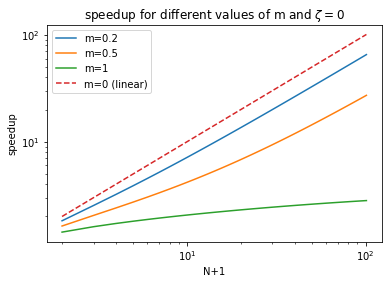

In [ ]:
X = np.linspace(1,100,100)
for m_ in [0.2, 0.5,1]:
    Y = g(X,m_)
    plt.plot(X+1,Y,label=f"m={m_}")
plt.plot(X+1,X+1,linestyle="dashed",label="m=0 (linear)")

plt.title(r"speedup for different values of m and $\zeta=0$")
plt.xlabel("N+1")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("speedup")
plt.legend()

plt.savefig("speedupM2.pdf")

## Default parameters

In [5]:
sigma = 10  # this is sigma_0 the individual gradient noise level
K = 100     # number of trials over which we average
T = int(5e5)# Horizon T
N = 10      # Default number of collaborators

## Comparing Alone training vs WGA vs BC

In [ ]:
def fi(x,i):
    if i==0 :
      return .5  * (x - 1)**2
    else :
      return .5  * 2 * (x - 5 )**2

def gradfi(x,i):
    if i==0 :
      return x - 1
    else :
      return 2 * (x - 5)

In [ ]:
### Alone training
etas = [5e-3,1e-4,1e-3,8e-4,2e-4,5e-4] #+ [10**(-i) for i in range(2,6)] #different step sizes
Res  = {}
for eta in etas :
  print("eta = ",eta)
  Out1 = np.zeros(T)
  for _ in range(K):
    x = np.random.randn()
    n0 = np.random.randn(T) * sigma
    L1 = [fi(x,0)]
    for i in range(1,T) :
      g0 = gradfi(x,0) + n0[i]
      x = x - eta * g0
      L1.append(fi(x,0))

    Out1 += np.array(L1)
  Out1 /= K
  Res[eta] = Out1


eta =  0.005
eta =  0.0001
eta =  0.001
eta =  0.0008
eta =  0.0002
eta =  0.0005


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


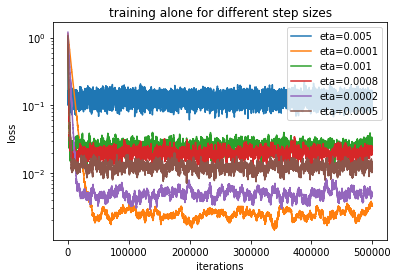

In [ ]:
ResAlone = Res
for eta in ResAlone:
  plt.plot(ResAlone[eta],label=f"eta={eta}")


plt.title("training alone for different step sizes")
plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()

Best $\eta=1e-4$

In [ ]:
### Alone training for best eta
T = int(7e5)
etas = [1e-4]
Res  = {}

for eta in etas :
  print("eta = ",eta)
  Out1 = np.zeros(T)
  for _ in range(K):
    x = np.random.randn()
    n0 = np.random.randn(T) * sigma
    L1 = [fi(x,0)]
    for i in range(1,T) :
      g0 = gradfi(x,0) + n0[i]
      x = x - eta * g0
      L1.append(fi(x,0))

    Out1 += np.array(L1)
  Out1 /= K
  Res[eta] = Out1


eta =  0.0001


In [ ]:
ResAlone = Res

In [ ]:
## WGA
eta = 1e-4
alphas = [1e-3]
Res = {}
for alpha in alphas:
  Out = np.zeros(T)
  # Gradients
  OutG = np.zeros(T)
  print("alpha=",alpha)
  for _ in range(K):
    x = np.random.randn()
    n0 = np.random.randn(T) * sigma
    n1 = np.random.randn(T) * sigma / np.sqrt(N)
    L = [fi(x,0)]
    G = [np.abs(gradfi(x,0))]
    for i in range(1,T) :
       g0 = gradfi(x,0) + n0[i]
       g1 = gradfi(x,1) + n1[i]
       x = x - eta * ( (1 - alpha) * g0 + alpha * g1)
       L.append(fi(x,0))
       G.append(np.abs(gradfi(x,0)))
    Out += np.array(L)
    OutG += np.array(G)
  Out /= K
  OutG /= K

  Res[alpha] = {"loss": Out, "gradient": OutG}

alpha= 0.001


In [ ]:
ResWGA = Res

In [ ]:
eta = 1e-4
betas = [1e-4]
Res = {}
for beta in betas:
  Out = np.zeros(T)
  # Gradients
  OutG = np.zeros(T)
  
  print("beta=",beta)
  alpha = N / ((N + 1) * 2 / (2 - beta))
  for _ in range(K):
    x = np.random.randn()
    n0 = np.random.randn(T) * sigma
    n1 = np.random.randn(T) * sigma / np.sqrt(N)
    L = [fi(x,0)]
    G = [np.abs(gradfi(x,0))]
    c = 0
    for i in range(1,T) :
       g0 = gradfi(x,0) + n0[i]
       g1 = gradfi(x,1) + n1[i]
       x = x - eta * ( (1 - alpha) * g0 + alpha * g1 - alpha * c)
       bias = g1 - g0
       c = (1 - beta) * c + beta * bias
       L.append(fi(x,0))
       G.append(np.abs(gradfi(x,0)))
    Out += np.array(L)
    OutG += np.array(G)
  Out /= K
  OutG /= K
  Res[beta] = {"loss": Out, "gradient": OutG}

beta= 0.0001


In [ ]:
ResBC = Res

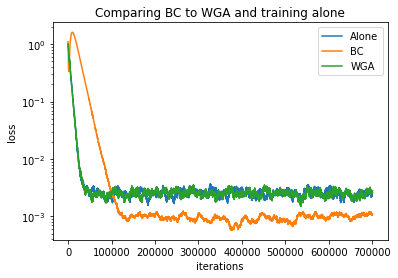

In [ ]:
plt.plot(ResAlone[1e-4],label="Alone")
plt.plot(ResBC[1e-4]["loss"],label=f"BC")
plt.plot(ResWGA[1e-3]["loss"],label=f"WGA")
plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Comparing BC to WGA and training alone")
plt.legend()


plt.savefig("BCvsWGAvsAlone.pdf")

## Effect of $\zeta$ on BC

In [ ]:
T = int(7e5)

zetas = [10**i for i in range(1,6)]

eta = 1e-4
beta = 1e-4

Res = {}

for zeta in zetas : 
  print("zeta = ", zeta)

  

  def fi(x,i):
    if i==0 :
      return .5  * (x - 1)**2
    else :
      return .5  * 2 * (x - 1 - zeta )**2

  def gradfi(x,i):
    if i==0 :
      return x - 1
    else :
      return 2 * (x - 1 - zeta)

  Out = np.zeros(T)
  # Gradients
  OutG = np.zeros(T)

  alpha = N / ((N + 1) * 2 / (2 - beta))
  for _ in range(K):
    x = np.random.randn()
    n0 = np.random.randn(T) * sigma
    n1 = np.random.randn(T) * sigma / np.sqrt(N)
    L = [fi(x,0)]
    G = [np.abs(gradfi(x,0))]
    c = 0
    for i in range(1,T) :
       g0 = gradfi(x,0) + n0[i]
       g1 = gradfi(x,1) + n1[i]
       x = x - eta * ( (1 - alpha) * g0 + alpha * g1 - alpha * c)
       bias = g1 - g0
       c = (1 - beta) * c + beta * bias
       L.append(fi(x,0))
       G.append(np.abs(gradfi(x,0)))
    Out += np.array(L)
    OutG += np.array(G)
  Out /= K
  OutG /= K

  Res[zeta] = {"loss": Out, "gradient": OutG}

zeta =  10
zeta =  100
zeta =  1000
zeta =  10000
zeta =  100000


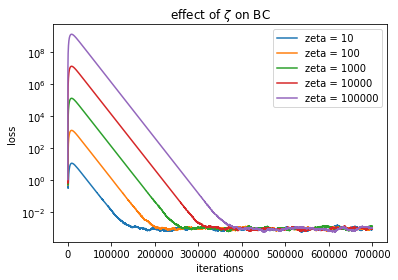

In [ ]:
WhatToPlot = "loss"
for zeta in zetas:
  plt.plot(Res[zeta][WhatToPlot],label=f"zeta = {zeta}")

plt.title(r"effect of $\zeta$ on BC")
plt.ylabel("loss")
plt.xlabel("iterations")
plt.yscale("log")
plt.legend()

## Effect of $\zeta$ on WGA as a function of the number of iterations

In [6]:
zetas = [10**i for i in range(1,6)]
T = int(7e5)
eta = 5e-4 # step size
alpha = 1e-3 #small value of alpha

Res = {}

for zeta in zetas : 
  print("zeta = ", zeta)

  def fi(x,i):
    if i==0 :
      return .5  * (x - 1)**2
    else :
      return .5  * 2 * (x - 1 - zeta )**2

  def gradfi(x,i):
    if i==0 :
      return x - 1
    else :
      return 2 * (x - 1 - zeta)

  Out = np.zeros(T)
  # Gradients
  OutG = np.zeros(T)

  for _ in range(K):
    x = np.random.randn()
    n0 = np.random.randn(T) * sigma
    n1 = np.random.randn(T) * sigma / np.sqrt(N)
    L = [fi(x,0)]
    G = [np.abs(gradfi(x,0))]
    for i in range(1,T) :
       g0 = gradfi(x,0) + n0[i]
       g1 = gradfi(x,1) + n1[i]
       x = x - eta * ( (1 - alpha) * g0 + alpha * g1)
       L.append(fi(x,0))
       G.append(np.abs(gradfi(x,0)))
    Out += np.array(L)
    OutG += np.array(G)
  Out /= K
  OutG /= K

  Res[zeta] = {"loss": Out, "gradient": OutG}

zeta =  10
zeta =  100
zeta =  1000
zeta =  10000
zeta =  100000


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


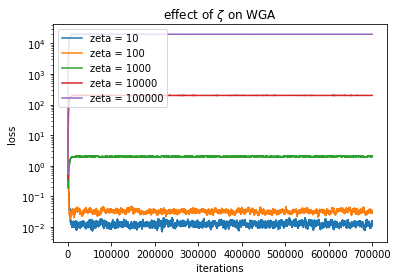

In [7]:
WhatToPlot = "loss"
for zeta in zetas:
  plt.plot(Res[zeta][WhatToPlot],label=f"zeta = {zeta}")

plt.title(r"effect of $\zeta$ on WGA")
plt.ylabel("loss")
plt.xlabel("iterations")
plt.yscale("log")
plt.legend()

## Studying the effect of $N$ on BC




In [8]:
def fi(x,i):
    if i==0 :
      return .5  * (x - 1)**2
    else :
      return .5  * 2 * (x - 5 )**2

def gradfi(x,i):
    if i==0 :
      return x - 1
    else :
      return 2 * (x - 5)

In [9]:
Ns = [1,10,20,50]
T=int(7e5)
eta = 5e-4
beta = 1e-4
Res = {} #Dictionary to store results

for i,N in enumerate(Ns) : 
  print("N = ", N)
  Out = np.zeros(T)
  # Gradients
  OutG = np.zeros(T)

  alpha = N / (N + 1)
  for _ in range(K):
    x = np.random.randn()
    n0 = np.random.randn(T) * sigma
    n1 = np.random.randn(T) * sigma / np.sqrt(N)
    L = [fi(x,0)]
    G = [np.abs(gradfi(x,0))]
    c = 0
    for i in range(1,T) :
       g0 = gradfi(x,0) + n0[i]
       g1 = gradfi(x,1) + n1[i]
       x = x - eta * ( (1 - alpha) * g0 + alpha * g1 - alpha * c)
       bias = g1 - g0
       c = (1 - beta) * c + beta * bias
       L.append(fi(x,0))
       G.append(np.abs(gradfi(x,0)))
    Out += np.array(L)
    OutG += np.array(G)
  Out /= K
  OutG /= K

  Res[N] = {"loss": Out, "gradient": OutG}

N =  1
N =  10
N =  20
N =  50


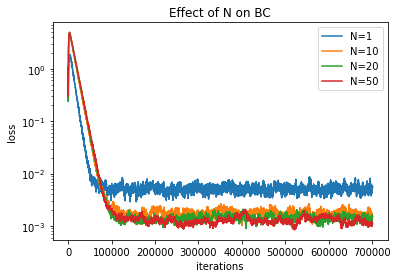

In [10]:
 for N in Res:
  plt.plot(Res[N]["loss"],label=f"N={N}")

plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("loss")

plt.title("Effect of N on BC")
plt.legend()

plt.savefig("EffectOfN3.pdf")